In [1]:
import numpy as np
import scipy.stats
import scipy.ndimage.filters
import matplotlib.pyplot as plt
from _glm_hmm import GLMHMMEstimator
from scipy.io import loadmat

In [2]:
num_samples = 5
num_states = 2
num_emissions = 2
num_feedbacks = 3
num_filter_bins = 30
num_steps = 1
filter_offset = 1

In [3]:
tau = 4
total_time = 10000
noiseSD = 0.1
stim_scale = 1
num_real_states = 2

In [4]:
stim = []
states = []
output_stim = []
output_trace = []

In [5]:
for ns in range(0, num_samples):
    output = np.zeros((num_real_states, total_time))
    
    stim_temp = np.zeros((num_filter_bins, total_time + num_filter_bins - 1, num_feedbacks))
    stim_temp[0, :, :] = scipy.ndimage.filters.gaussian_filter(np.random.randn(total_time + num_filter_bins - 1, num_feedbacks), stim_scale)

    for i in range(1, num_filter_bins):
        stim_temp[i, 0:total_time, :] = stim_temp[0, i:(total_time + i), :]
    
    stim.append(stim_temp[:, 0:total_time, :] + np.random.randn(num_filter_bins, total_time, num_feedbacks) * noiseSD)
    filt = scipy.stats.gamma.pdf(np.linspace(0, num_filter_bins), a = tau)[0:num_filter_bins]

    p1 = np.exp(np.matmul(stim[ns][:, :, 0].T, filt.T) + np.matmul(stim[ns][:, :, 1].T, -filt.T))
    output[0, :] = p1 / (1 + p1) > 0.5
    p2 = np.exp(np.matmul(stim[ns][:, :, 0].T, -filt.T) + np.matmul(stim[ns][:, :, 1].T, filt.T))
    output[1, :] = p2 / (1 + p2) > 0.5

    p3 = np.exp(np.matmul(stim[ns][:, :, 2].T, filt.T))
    states.append(p3 / (1 + p3) > 0.5)

    output_trace.append(np.zeros(total_time))
    for ss in range(0, num_real_states):
        output_trace[ns][states[ns] == ss] = output[ss][states[ns] == ss]

    final_stim = np.append(stim[ns][:, :, 0], stim[ns][:, :, 1], axis = 0)
    final_stim = np.append(final_stim, stim[ns][:, :, 2], axis = 0)
    final_stim = np.append(final_stim, np.ones((1, total_time)), axis = 0)
    output_stim.append(final_stim)

In [6]:
estimator = GLMHMMEstimator(num_samples = num_samples, num_states = num_states, num_emissions = num_emissions, num_feedbacks = num_feedbacks, num_filter_bins = num_filter_bins, num_steps = num_steps, filter_offset = filter_offset)
estimator.fit(output_stim, output_trace, [])
estimator.predict(output_stim)

Fitting iteration:   1
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.263e-01  |  3.495e-02  |  2.991e-02  |  3.000e+00  |  4.000e+00  
  2.000e+00  |  1.908e-01  |  2.245e-02  |  4.023e-01  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  1.842e-01  |  1.250e-02  |  1.167e-01  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  1.816e-01  |  6.421e-03  |  1.959e-01  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  1.810e-01  |  2.409e-03  |  7.409e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  1.809e-01  |  1.326e-03  |  3.160e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  1.808e-01  |  1.139e-03  |  3.226e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  1.807e-01  |  1.244e-03  |  3.845e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  1.806e-01  |  2.624e-03  |  1.441e-01  |  1.000e+00

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.586e-01  |  3.611e-05  |  6.251e-05  |  3.000e+00  |  4.000e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 4
F: 0.2586221396923065
||g||: 3.610765634221025e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.228e+01  |  2.623e+01  |  0.000e+00  |  1.020e+02  |  0.000e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 103
F: 22.282997131347656
||g||: 26.229854583740234
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|

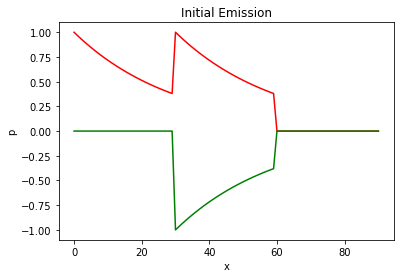

In [7]:
plt.figure()
plt.title("Initial Emission")
plt.xlabel("x")
plt.ylabel("p")
plt.plot(range(0, 91), estimator.emit_w_init_[0, 0, :], "-r")
plt.plot(range(0, 91), estimator.emit_w_init_[1, 0, :], "-g")
plt.show()

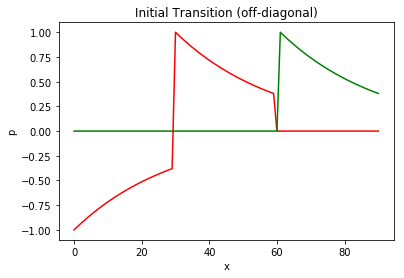

In [8]:
plt.figure()
plt.title("Initial Transition (off-diagonal)")
plt.xlabel("x")
plt.ylabel("p")
plt.plot(range(0, 91), estimator.trans_w_init_[0, 1, :], "-r")
plt.plot(range(0, 91), estimator.trans_w_init_[1, 0, :], "-g")
plt.show()

In [9]:
data = loadmat('GLMHMM_output.mat')
emit_w_final = data['output'][0][-1]['emit_w'][0][0]
trans_w_final = data['output'][0][-1]['trans_w'][0][0]
print(emit_w_final.shape)
print(trans_w_final.shape)

(2, 1, 91)
(2, 2, 91)


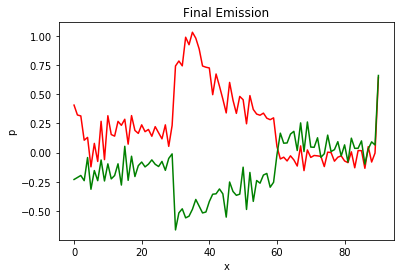

In [10]:
plt.figure()
plt.title("Final Emission")
plt.xlabel("x")
plt.ylabel("p")
plt.plot(range(0, 91), emit_w_final[0, 0, :], "-r")
plt.plot(range(0, 91), emit_w_final[1, 0, :], "-g")
plt.show()

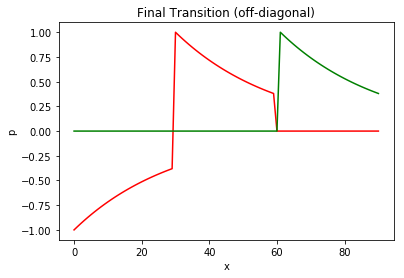

In [11]:
plt.figure()
plt.title("Final Transition (off-diagonal)")
plt.xlabel("x")
plt.ylabel("p")
plt.plot(range(0, 91), trans_w_final[0, 1, :], "-r")
plt.plot(range(0, 91), trans_w_final[1, 0, :], "-g")
plt.show()